## Project Setup

In [104]:
# All import statements needed for the project
import os
import re
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import pyarrow.parquet as pq
import geopandas as gpd
import warnings
from typing import List, Tuple, Dict
import sqlite3
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.animation as animation
from IPython.display import HTML

In [105]:
TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [106]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # The directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Common Functions

In [107]:
def get_html() -> bytes:
    """
    Request the HTML content of TLC_URL webpage.

    Returns:
        bytes: The HTML content of the webpage in bytes type.
    """
    response = requests.get(TLC_URL)
    html = response.content
    
    return html

In [108]:
def find_taxi_parquet_links()-> List[str]:
    """
    Finds and returns a list of URLs of Yellow Taxi parquet files.

    Returns:
        List[str]: a list of strings representing URLs of Yellow Taxi 
        parquet files.
    """
    parquet_links = list()
    
    html = get_html()
    soup = bs4.BeautifulSoup(html, "html.parser")
    links = soup.find_all("a")
    # Using re module to help extract links for Yellow Taxi
    pattern = re.compile(r"Yellow Taxi Trip Records")
    for link in links:
        title = link.get('title')
        if title != None:
            match = pattern.search(title)
            if match:
                # Collect URLs of Yellow Taxi parquet files
                parquet_links.append(link.get('href'))
                
    return parquet_links

In [109]:
def find_HVFHV_parquet_links() -> List[str]:
    """
    Finds and returns a list of URLs of High Volume FHV parquet files.

    Returns:
        List[str]: a list of strings representing URLs of High Volume FHV 
            parquet files.
    """
    parquet_links = list()
    
    html = get_html()
    soup = bs4.BeautifulSoup(html, "html.parser")
    links = soup.find_all("a")
    # Using re module to extract links for High Volume For-Hire Vehicle
    pattern = re.compile(r"High Volume For-Hire Vehicle Trip Records")
    for link in links:
        title = link.get('title')
        if title != None:
            match = pattern.search(title)
            if match:
                # Collect URLs of HVFHV parquet files
                parquet_links.append(link.get('href'))
                
    return parquet_links

### Downloading Taxi files

In [110]:
def download_taxi_parquet_files():
    """
    Downloads Yellow Taxi parquet files from URLs found by 'find_taxi_
    parquet_links()'.

    Returns:
        None
    """
    taxi_files = find_taxi_parquet_links()
    for file_url in taxi_files:
        file_url = file_url.replace(' ', '')
        name = file_url.split('trip-data/')[1]
        # Check if the file already exists
        if os.path.exists(name):
            pass
        else:
            response = requests.get(file_url, stream=True)
            with open(name, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

In [111]:
# Call function to download yellow_taxi_files programmatically
download_taxi_parquet_files()

### Downloading HVFHV files

In [112]:
def download_HVFHV_parquet_files() -> None:
    """
    Downloads High Volume FHV parquet files from URLs found by 'find_
    HVFHV_parquet_links'.

    Returns:
        None
    """
    taxi_files = find_HVFHV_parquet_links()
    for file_url in taxi_files:
        file_url = file_url.replace(' ', '')
        name = file_url.split('trip-data/')[1]
        # Check if the file already exists
        if os.path.exists(name):
            pass
        else:
            response = requests.get(file_url, stream=True)
            with open(name, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

In [113]:
# Call function to download HVFHV_parquet_files programmatically
download_HVFHV_parquet_files()

### Load Taxi Zones

In [114]:
def load_taxi_zones(shapefile: str) -> gpd.GeoDataFrame:
    """
    Read a shapefile containing taxi zones into a GeoDataFrame.

    Parameters:
        shapefile(str):
            The path to the shapefile that contains the taxi zones data.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame that contains the taxi zones data.
    """
    data = gpd.read_file(shapefile)
    
    return data

In [115]:
# Load and store taxi zones data
loaded_taxi_zones = load_taxi_zones('taxi_zones.shp')
loaded_taxi_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [116]:
def lookup_coords_for_taxi_zone_id(
        zone_loc_id: int,
        loaded_taxi_zones: gpd.GeoDataFrame
    ) -> Tuple[float, float]:
    """
    Lookup the coordinates of for a given taxi zone Location ID.

    Parameters:
        zone_loc_id(int): The location ID for the taxi zone
        loaded_taxi_zones(gpd.GeoDataFrame):
            A GeoDataFrame that contains taxi zone geometries.

    Returns:
        Tuple[float, float]: A tuple containing the longitude and latitude 
        of the given location ID. 
        Returns (None, None) if the ID is not found.
    """
    row = loaded_taxi_zones[loaded_taxi_zones['LocationID']==zone_loc_id]
    if (len(row)!=0):
        # Coordinate reference system 4326
        row = row.to_crs(4326)
        # Extract centroid
        centroid = row.geometry.centroid.iloc[0]

        return centroid.x, centroid.y
    else:
        return None, None

### Calculate Sample Size

In [117]:
def calculate_sample_size(p: float, e: float, z: float) -> float:
    """
    Calculate the sample size using Cochran's Formula.

    Parameters:
        p (float): the (estimated) proportion of the population.
        e (float): the desired level of precision.
        z (float): Z values based on the confidence level.

    Returns:
        float: The sample size calculated by Cochran's Formula.
    """
    n0 = ((z**2)*p*(1-p))/(e**2)
    
    return n0

### Process Taxi Data

In [118]:
def get_and_clean_taxi_month(url: str) -> pd.DataFrame:
    """
    Extract a sample of taxi data from the dataset of given url and clean it.

    Parameters:
        url (str):
            The URL of the Parquet file containing the Yellow Taxi data.

    Returns:
        pd.DataFrame:
            A cleaned DataFrame containing the relevant columns and data.
    """
    # Get file's name from url
    file_url = url.replace(' ', '')
    name = file_url.split('trip-data/')[1]

    # Only extract a specific sample size of data
    sample = int(calculate_sample_size(p=0.5, e=0.05, z=1.96))
    # Read a sample of data by calling its name
    data = pq.read_table(name).to_pandas().sample(n=sample, random_state=1)
    
    # Extract specific columns we want (there are three types of dataframes)

    # The first type of dataset
    if ('VendorID' in data.columns):
        # Clean values in columns before adding them up as a total surcharge
        data = data.rename(
            columns={
                'airport_fee': 'Airport_fee',
                'Airport_Fee': 'Airport_fee'
            }
        )
        data['Airport_fee'] = data['Airport_fee'].fillna(0)
        data = data.dropna(
            subset=[
                'improvement_surcharge', 'congestion_surcharge',
                'extra', 'tip_amount'
            ],
            how='any'
        )
        data = data[~(
            data[
                [
                    'improvement_surcharge', 'congestion_surcharge',
                    'extra', 'tip_amount', 'Airport_fee'
                ]
            ] < 0
        ).any(axis=1)]
        
        # Define new columns for storing information(coordinates and surcharge)
        data['pickup_longitude'] = None
        data['pickup_latitude'] = None
        data['dropoff_longitude'] = None
        data['dropoff_latitude'] = None
        data['surcharge'] = None
        # Use shp to find lat and lon for pickup/dropoff location
        drop_index = list()
        for index, row in data.iterrows():
            lon, lat = lookup_coords_for_taxi_zone_id(
                row['PULocationID'],loaded_taxi_zones
            )
            lon2, lat2 = lookup_coords_for_taxi_zone_id(
                row['DOLocationID'],loaded_taxi_zones
            )
            if (lon != None and lat != None and lon2 != None and lat2 != None):
                data.loc[index,'pickup_longitude'] = lon
                data.loc[index,'pickup_latitude'] = lat
                data.loc[index,'dropoff_longitude'] = lon2
                data.loc[index,'dropoff_latitude'] = lat2
            else:
                # Store rows where pickup and droppff locationID is not valid
                drop_index.append(index)
            # Calculate total surcharge of each taxi ride
            data.loc[index,'surcharge'] = (
                row['improvement_surcharge'] 
                + row['congestion_surcharge']
                + row['extra']
                + row['tip_amount']
                + row['Airport_fee']
            )
        # Drop rows where pickup locationID or dropoff locationID is not valid    
        data = data.drop(drop_index)
        # Only keep columns needed 
        data = data[
            [
                'VendorID','tpep_pickup_datetime', 'tpep_dropoff_datetime',
                'trip_distance','pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude','fare_amount',
                'surcharge', 'mta_tax', 'tolls_amount', 'tip_amount'
            ]
        ]       

    # The second type of dataset
    if ('vendor_id' in data.columns):
        # Clean values in columns before adding them up as a total surcharge
        data = data.dropna(subset=['surcharge', 'tip_amount'], how='any')
        # Calculate total surcharge of each taxi ride   
        data['surcharge2'] = data['surcharge'] + data['tip_amount']
        # Only keep columns needed 
        data = data[
            [
                'vendor_id','pickup_datetime','dropoff_datetime',
                'trip_distance', 'pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude', 'fare_amount',
                'surcharge2', 'mta_tax', 'tolls_amount', 'tip_amount'
            ]
        ]

    # The third type of dataset
    if ('vendor_name' in data.columns):
        # Clean values in columns before adding them up as a total surcharge
        data = data.dropna(subset=['surcharge', 'Tip_Amt'], how='any')  
        # Calculate total surcharge of each taxi ride    
        data['surcharge2'] = data['Tip_Amt'] + data['surcharge']
        # Only keep columns needed 
        data = data[
            [
                'vendor_name','Trip_Pickup_DateTime','Trip_Dropoff_DateTime',
                'Trip_Distance', 'Start_Lon', 'Start_Lat',
                'End_Lon', 'End_Lat', 'Fare_Amt',
                'surcharge2', 'mta_tax', 'Tolls_Amt', 'Tip_Amt'
            ]
        ]

    # Normalize column names
    new_column_names = [
        'VendorID', 'pickup_datetime', 'dropoff_datetime',
        'trip_distance', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'fare_amount',
        'surcharge', 'taxes', 'tolls_amount', 'tip_amount'
    ]
    data.columns = new_column_names

    # Normalize appropriate column types
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
    data['surcharge'] = pd.to_numeric(data['surcharge'])

    # Removing trips that start and/or end outside 
    # (40.560445, -74.242330) and (40.908524, -73.717047)
    data = data[
        (data['pickup_latitude'] >= 40.560445) &
        (data['pickup_latitude'] <= 40.908524) &
        (data['pickup_longitude'] >= -74.242330) &
        (data['pickup_longitude'] <= -73.717047) &
        (data['dropoff_latitude'] >= 40.560445) &
        (data['dropoff_latitude'] <= 40.908524) &
        (data['dropoff_longitude'] >= -74.242330) &
        (data['dropoff_longitude'] <= -73.717047)
    ]

    # Removing a distance of 0
    drop_index2 = list()
    for index, row in data.iterrows():
        # Drop rows with same pickup and dropoff location
        if (
            (row['pickup_longitude']==row['dropoff_longitude']) and 
            (row['pickup_latitude']==row['dropoff_latitude'])
        ):
            drop_index2.append(index)
    data = data.drop(drop_index2)
    # Drop rows with distance of 0 
    data = data[data['trip_distance'] > 0]

    # Removing invalid data points (NaN)
    data = data.dropna()

    return data

In [119]:
def get_and_clean_taxi_data(parquet_urls: List[str])-> pd.DataFrame:
    """
    Load and clean data from a list of URLs for Yellow Taxi Parquet files, and 
    combine them into one large DataFrame.

    Parameters:
        parquet_urls (list): A list of URLs of Parquet files.

    Returns:
        pd.DataFrame: A DataFrame containing all cleaned taxi data.
    """
    all_taxi_dataframes = []
    
    # Read and clean data from every month
    for parquet_url in parquet_urls:
        # Only consider files for yellow taxi
        if ('yellow' in parquet_url):
            dataframe = get_and_clean_taxi_month(parquet_url)
            all_taxi_dataframes.append(dataframe)
        
    # Create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    
    return taxi_data

In [120]:
def get_taxi_data() -> pd.DataFrame:
    """
    Find the links for all taxi data Parquet files, cleans the data, and returns 
    the DataFrame containing all the taxi data.

    Returns:
        pd.DataFrame: A DataFrame containing all the cleaned yellow-taxi data.
    """
    all_taxi_urls = find_taxi_parquet_links()
    taxi_data = get_and_clean_taxi_data(all_taxi_urls)

    return taxi_data

In [121]:
# The cleaned and complete taxi data
warnings.filterwarnings('ignore')
taxi_data = get_taxi_data()

In [122]:
taxi_data.head()

,VendorID,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,taxes,tolls_amount,tip_amount
1984133,2,2024-01-23 12:31:32,2024-01-23 12:45:26,1.25,-73.984196,40.759817,-73.989844,40.762252,13.5,3.50,0.5,0.0,0.00
2192612,2,2024-01-25 14:37:34,2024-01-25 15:15:01,15.65,-73.786533,40.646984,-73.936793,40.715369,61.8,19.01,0.5,0.0,16.26
124735,2,2024-01-02 18:47:41,2024-01-02 19:10:01,3.67,-73.985156,40.748574,-73.978632,40.783961,22.6,8.04,0.5,0.0,2.04
2400654,2,2024-01-27 14:35:35,2024-01-27 15:04:46,3.47,-73.984196,40.759817,-73.99738,40.72834,26.1,8.50,0.5,0.0,5.00
2108036,2,2024-01-24 17:00:51,2024-01-24 17:15:29,1.59,-73.954739,40.765483,-73.957011,40.780436,13.5,7.00,0.5,0.0,1.00


In [123]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28248 entries, 1984133 to 170745
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   VendorID           28248 non-null  object        
 1   pickup_datetime    28248 non-null  datetime64[ns]
 2   dropoff_datetime   28248 non-null  datetime64[ns]
 3   trip_distance      28248 non-null  float64       
 4   pickup_longitude   28248 non-null  object        
 5   pickup_latitude    28248 non-null  object        
 6   dropoff_longitude  28248 non-null  object        
 7   dropoff_latitude   28248 non-null  object        
 8   fare_amount        28248 non-null  float64       
 9   surcharge          28248 non-null  float64       
 10  taxes              28248 non-null  float64       
 11  tolls_amount       28248 non-null  float64       
 12  tip_amount         28248 non-null  float64       
dtypes: datetime64[ns](2), float64(6), object(5)
memory usage: 3

In [124]:
taxi_data.describe()

,pickup_datetime,dropoff_datetime,trip_distance,fare_amount,surcharge,taxes,tolls_amount,tip_amount
count,28248,28248,28248.000000,28248.000000,28248.000000,28248.000000,28248.000000,28248.000000
mean,2019-10-11 09:21:11.896842496,2019-10-11 09:37:36.769930496,3.159905,14.108583,5.823440,0.496400,0.390209,2.365508
min,2009-10-19 08:15:38,2009-10-19 08:28:21,0.010000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,2019-06-30 21:45:59,2019-06-30 21:57:19,1.100000,7.000000,2.800000,0.500000,0.000000,0.000000
50%,2021-04-04 19:00:06.500000,2021-04-04 19:04:37,1.800000,10.000000,5.530000,0.500000,0.000000,2.000000
75%,2022-12-20 08:40:55.750000128,2022-12-20 11:24:51.750000128,3.270000,15.600000,7.760000,0.500000,0.000000,3.160000
max,2024-09-30 21:00:16,2024-09-30 21:07:08,136.300000,190.000000,60.880000,0.800000,40.600000,56.830000
std,NaN,NaN,3.940122,12.555958,4.309306,0.045982,1.672154,3.041796


### Processing Uber Data

In [125]:
def get_and_clean_uber_month(url: str) -> pd.DataFrame:
    """
    Processes, and cleans Uber trip data for a given month.It downloads Uber 
    trip data from the specified URL, filters the data, normalizes columns, 
    and removes invalid or out-of-bound data. 

    Parameters:
        url (str): The URL of the Uber trip data file.

    Returns:
        pd.DataFrame: A cleaned DataFrame containing filtered and 
            normalized Uber trip data.
    """

    file_url = url.replace(' ', '')
    name = file_url.split('trip-data/')[1]
    data = pq.read_table(name).to_pandas()

    # Filter for Uber license
    data = data[data['hvfhs_license_num'] == "HV0003"]

    # Sample the data
    sample = int(calculate_sample_size(p=0.5, e=0.05, z=1.96))
    data = data.sample(n=sample, random_state=1)

    # Add geographic coordinates for pickup and dropoff locations
    if 'hvfhs_license_num' in data.columns:
        coords = data.apply(
            lambda row: pd.Series(
                lookup_coords_for_taxi_zone_id(
                    row['PULocationID'], loaded_taxi_zones
                ) + lookup_coords_for_taxi_zone_id(
                    row['DOLocationID'], loaded_taxi_zones
                )
            )
            if (row['PULocationID'] in loaded_taxi_zones['LocationID'] and
                row['DOLocationID'] in loaded_taxi_zones['LocationID'])
            else pd.Series([None, None, None, None]),
            axis=1
    )
    coords.columns = [
        'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude'
        ]
    data = pd.concat([data, coords], axis=1)

    # Drop NaN
    data = data.dropna(
        subset = [
            'pickup_longitude', 'pickup_latitude', 
            'dropoff_longitude', 'dropoff_latitude'
            ]
        )

    # Select columns
    data = data[
        [
            'request_datetime',
            'pickup_datetime',
            'dropoff_datetime',
            'trip_miles',
            'trip_time',
            'pickup_longitude',
            'pickup_latitude',
            'dropoff_longitude',
            'dropoff_latitude',
            'base_passenger_fare',
            'tolls',
            'bcf',
            'sales_tax',
            'congestion_surcharge',
            'airport_fee',
            'tips'
        ]
    ] 

    # Normalize appropriate column types - time
    data['request_datetime'] = pd.to_datetime(data['request_datetime'])
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
    
    # Normalize appropriate column types - number
    data['trip_miles'] = pd.to_numeric(data['trip_miles'])
    data['trip_time'] = pd.to_numeric(data['trip_time'])
    data['base_passenger_fare'] = pd.to_numeric(data['base_passenger_fare'])
    data['tolls'] = pd.to_numeric(data['tolls'])
    data['bcf'] = pd.to_numeric(data['bcf'])
    data['sales_tax'] = pd.to_numeric(data['sales_tax'])
    data['congestion_surcharge'] = pd.to_numeric(data['congestion_surcharge'])
    data['airport_fee'] = pd.to_numeric(data['airport_fee'])
    data['tips'] = pd.to_numeric(data['tips'])
    
    # Clean relevant columns before adding them up as a total surcharge
    data['airport_fee'] = data['airport_fee'].fillna(0)
    data = data.dropna(
        subset=['airport_fee', 'congestion_surcharge', 'bcf', 'tips'],
        how='any'
    )
    
    # Compute total surcharge
    data['all_surcharge'] = (
        data['congestion_surcharge']
        + data['airport_fee']
        + data['bcf']
        + data['tips']
    )
    
    # Remove NaN
    data = data.dropna()
    
    # Normalize column names (pu, do, trip_time, bcf)
    new_column_names = [
        'request_datetime',
        'pickup_datetime',
        'dropoff_datetime',
        'trip_miles',
        'trip_time_seconds',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        'base_passenger_fare',
        'tolls',
        'black_car_fund',
        'sales_tax',
        'congestion_surcharge',
        'airport_fee',
        'tips',
        'all_surcharge'
    ]
    data.columns = new_column_names

    # Remove invalid time
    data = data[data['pickup_datetime'] < data['dropoff_datetime']]
    # Remove 0 distance
    data = data[data['trip_miles'] > 0]
    # Remove 0 time
    data = data[data['trip_time_seconds'] > 0]
    
    # Removing trips that start and/or end outside 
    # (40.560445, -74.242330) and (40.908524, -73.717047)
    data = data[
        (data['pickup_latitude'] >= 40.560445) &
        (data['pickup_latitude'] <= 40.908524) &
        (data['pickup_longitude'] >= -74.242330) &
        (data['pickup_longitude'] <= -73.717047) &
        (data['dropoff_latitude'] >= 40.560445) &
        (data['dropoff_latitude'] <= 40.908524) &
        (data['dropoff_longitude'] >= -74.242330) &
        (data['dropoff_longitude'] <= -73.717047)
    ]

    return data

In [126]:
def get_and_clean_uber_data(parquet_urls: List[str]) -> pd.DataFrame:
    """
    Load and clean data from a list of URLs for fhvhv files, and combine them 
    into one large DataFrame.

    Parameters:
        parquet_urls (List[str]): 
            A list of URLs for Parquet files containing Uber data.

    Returns:
        pd.DataFrame: 
            A cleaned and combined DataFrame containing Uber trip data 
            from all specified Parquet files.
    """
    all_uber_dataframes = []
    
    # Process each URL in the list
    for parquet_url in parquet_urls:
        # Only consider fhvhv data
        if ('fhvhv' in parquet_url):
            dataframe = get_and_clean_uber_month(parquet_url)
            all_uber_dataframes.append(dataframe)
        
    uber_data = pd.concat(all_uber_dataframes)
    
    return uber_data

In [127]:
def get_uber_data() -> pd.DataFrame:
    """
    Retrieves all relevant uber URLs from the TLC page,
    and combined all cleaned datas as one DataFrame.

    Returns:
        pd.DataFrame: 
            A cleaned DataFrame containing Uber trip data
            from all relevant Parquet files.
    """
    all_uber_urls = find_HVFHV_parquet_links()
    uber_data = get_and_clean_uber_data(all_uber_urls)
    return uber_data

In [128]:
warnings.filterwarnings('ignore')
uber_data = get_uber_data()

In [129]:
uber_data.head()

,request_datetime,pickup_datetime,dropoff_datetime,trip_miles,trip_time_seconds,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,base_passenger_fare,tolls,black_car_fund,sales_tax,congestion_surcharge,airport_fee,tips,all_surcharge
13768987,2024-01-22 19:51:20,2024-01-22 19:53:55,2024-01-22 20:02:16,0.76,501,-73.984052,40.736823,-73.996971,40.742278,10.83,0.0,0.30,0.96,2.75,0.0,0.0,3.05
15852136,2024-01-26 07:04:02,2024-01-26 07:15:36,2024-01-26 07:33:32,2.63,1076,-73.939287,40.674469,-73.876821,40.660935,22.50,0.0,0.62,2.00,0.00,0.0,0.0,0.62
17488284,2024-01-28 10:58:43,2024-01-28 11:00:16,2024-01-28 11:10:59,3.01,643,-73.985937,40.727620,-73.954739,40.765483,15.42,0.0,0.42,1.37,2.75,0.0,7.0,10.17
9923321,2024-01-17 10:34:49,2024-01-17 10:37:10,2024-01-17 10:41:40,0.61,270,-74.002875,40.734575,-73.997380,40.728340,8.24,0.0,0.23,0.73,2.75,0.0,0.0,2.98
17511019,2024-01-28 11:45:05,2024-01-28 11:47:53,2024-01-28 11:50:00,0.35,127,-73.957418,40.718803,-73.959905,40.710879,8.87,0.0,0.24,0.79,0.00,0.0,0.0,0.24


In [130]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24796 entries, 13768987 to 1818047
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   request_datetime      24796 non-null  datetime64[us]
 1   pickup_datetime       24796 non-null  datetime64[us]
 2   dropoff_datetime      24796 non-null  datetime64[us]
 3   trip_miles            24796 non-null  float64       
 4   trip_time_seconds     24796 non-null  int64         
 5   pickup_longitude      24796 non-null  float64       
 6   pickup_latitude       24796 non-null  float64       
 7   dropoff_longitude     24796 non-null  float64       
 8   dropoff_latitude      24796 non-null  float64       
 9   base_passenger_fare   24796 non-null  float64       
 10  tolls                 24796 non-null  float64       
 11  black_car_fund        24796 non-null  float64       
 12  sales_tax             24796 non-null  float64       
 13  congestion_s

In [131]:
uber_data.describe()

,request_datetime,pickup_datetime,dropoff_datetime,trip_miles,trip_time_seconds,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,base_passenger_fare,tolls,black_car_fund,sales_tax,congestion_surcharge,airport_fee,tips,all_surcharge
count,24796,24796,24796,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000,24796.000000
mean,2021-11-28 03:20:39.746935,2021-11-28 03:25:20.320293,2021-11-28 03:43:17.410308,4.354697,1076.146758,-73.935481,40.738280,-73.934960,40.737618,20.186397,0.619235,0.561364,1.806698,1.027807,0.107376,0.738344,2.434890
min,2019-02-01 06:55:47,2019-02-01 07:06:21,2019-02-01 07:36:24,0.010000,4.000000,-74.170887,40.561994,-74.174000,40.561994,-13.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2020-06-27 17:02:36.500000,2020-06-27 17:05:22.500000,2020-06-27 17:28:11.500000,1.520000,556.000000,-73.984196,40.691507,-73.984196,40.690786,9.780000,0.000000,0.250000,0.860000,0.000000,0.000000,0.000000,0.320000
50%,2021-11-26 01:27:10.500000,2021-11-26 01:33:12.500000,2021-11-26 01:44:34,2.800000,879.000000,-73.948789,40.737698,-73.948136,40.737698,15.590000,0.000000,0.420000,1.370000,0.000000,0.000000,0.000000,0.970000
75%,2023-04-29 17:37:17.500000,2023-04-29 17:42:25.250000,2023-04-29 17:57:41.750000,5.550000,1377.000000,-73.900316,40.774375,-73.899536,40.774375,25.292500,0.000000,0.720000,2.270000,2.750000,0.000000,0.000000,3.420000
max,2024-09-30 23:19:11,2024-09-30 23:22:27,2024-09-30 23:28:28,63.770000,13260.000000,-73.726656,40.899529,-73.726656,40.899529,168.250000,53.000000,8.400000,15.710000,5.500000,5.000000,50.000000,53.360000
std,NaN,NaN,NaN,4.262520,745.367722,0.064342,0.068792,0.067355,0.069172,15.311116,2.426813,0.502849,1.423495,1.322972,0.507743,2.266388,3.191714


### Processing Weather Data

In [132]:
def get_all_weather_csvs() -> List[pd.DataFrame]:
    """
    Reads weather data for the years 2020 to 2024 and returns a list of 
    DataFrames for each year.

    Returns:
        List[pd.DataFrame]:
        A list of DataFrames containing weather data for each year.
    """
    all_weather_files = list()
    # Iterate each year from 2020 to 2024
    for i in range(2020,2025,1):
        # Read weather data from specific year
        weather_file = pd.read_csv(f'{i}'+'_weather.csv')
        all_weather_files.append(weather_file)
    
    return all_weather_files

In [133]:
def clean_month_weather_data_hourly(csv_file: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans weather data by extracting the hour from the 'DATE' column,
    fixing invalid values in 'HourlyPrecipitation' and 'HourlyWindSpeed',
    and return the cleaned data in DataFrame.

    Parameter:
        csv_file (pd.DataFrame): 
            The input file of date containing weather information.

    Returns:
        pd.DataFrame: 
            A cleaned DataFrame with 'DATE', 'hour', 'HourlyPrecipitation',
            and 'HourlyWindSpeed'.
    """
    hour_data = csv_file.copy()
    # Convert date in datetime foramt and extract hour
    hour_data['DATE'] = pd.to_datetime(hour_data['DATE'])
    hour_data['hour'] = hour_data['DATE'].dt.hour
    hour_data['DATE'] = hour_data['DATE'].dt.strftime('%Y-%m-%d')
    hour_data['DATE'] = pd.to_datetime(hour_data['DATE'])
    
    # Fix invalid values for HourlyPrecipitation
    hour_data['HourlyPrecipitation'] = (
        hour_data['HourlyPrecipitation']
        .replace('T', 0)
    )
    hour_data['HourlyPrecipitation'] = (
        hour_data['HourlyPrecipitation']
        .str.replace('s', '')
    )
    hour_data['HourlyPrecipitation'] = (
        hour_data['HourlyPrecipitation'].fillna(0)
    )
    hour_data['HourlyPrecipitation'] = (
        pd.to_numeric(hour_data['HourlyPrecipitation'])
    )
    # Fix invalid values for HourlyWindSpeed
    hour_data['HourlyWindSpeed'] = hour_data['HourlyWindSpeed'].fillna(0)
    hour_data['HourlyWindSpeed'] = pd.to_numeric(hour_data['HourlyWindSpeed'])
    
    hour_data = (
        hour_data[['DATE','hour','HourlyPrecipitation','HourlyWindSpeed']]
        .reset_index(drop=True)
    )
    
    return hour_data

In [134]:
def clean_month_weather_data_daily(csv_file: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans daily weather data by extracting daily record time,
    fixing invalid values,
    and returning a cleaned DataFrame with relevant columns.

    Parameters:
        csv_file (pd.DataFrame): The input DataFrame containing weather data.

    Returns:
        pd.DataFrame: A cleaned DataFrame with 'DATE', 'DailyPrecipitation', 
        'DailyAverageWindSpeed', and 'DailySnowfall'.
    """
    daily_data = csv_file.copy()
    # Convert 'DATE' to datetime format 
    # And extract weather information when time is 23:59
    daily_data['DATE'] = pd.to_datetime(daily_data['DATE'])
    daily_data = daily_data[daily_data['DATE'].dt.strftime('%H:%M') == '23:59']
    daily_data['DATE'] = daily_data['DATE'].dt.strftime('%Y-%m-%d')
    daily_data = daily_data[
        ~(
            daily_data.duplicated(['DATE'], keep=False) &
            (daily_data['DailyPrecipitation'].isna()) &
            (daily_data['DailyAverageWindSpeed'].isna()) &
            (daily_data['DailySnowfall'].isna())
        )
    ]
    
    daily_data['DATE'] = pd.to_datetime(daily_data['DATE'])
    
    # Fix invalid values for DailyPrecipitation
    daily_data['DailyPrecipitation'] = (
        daily_data['DailyPrecipitation'].replace('T', 0)
    )
    daily_data['DailyPrecipitation'] = (
        daily_data['DailyPrecipitation'].fillna(0)
    )
    daily_data['DailyPrecipitation'] = (
        pd.to_numeric(daily_data['DailyPrecipitation'])
    )

    # Fix invalid values for DailyAverageWindSpeed
    daily_data['DailyAverageWindSpeed'] = (
        daily_data['DailyAverageWindSpeed'].fillna(0)
    )
    daily_data['DailyAverageWindSpeed'] = (
        pd.to_numeric(daily_data['DailyAverageWindSpeed'])
    )

    # Fix invalid values for DailyAverageWindSpeed
    daily_data['DailySnowfall'] = daily_data['DailySnowfall'].replace('T', 0)
    daily_data['DailySnowfall'] = daily_data['DailySnowfall'].fillna(0)
    daily_data['DailySnowfall'] = pd.to_numeric(daily_data['DailySnowfall'])
    
    daily_data = daily_data[
        ['DATE','DailyPrecipitation','DailyAverageWindSpeed','DailySnowfall']
    ].reset_index(drop=True)
    
    return daily_data

In [135]:
def load_and_clean_weather_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Loads and cleans weather data into hourly and daily dataframes 
    from CSV files.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]:
            A tuple containing hourly_data and daily_data
    """
    weather_csv_files = get_all_weather_csvs()
    
    hourly_dataframes = []
    daily_dataframes = []
    
    # Receives hourly weather data and daily weather data for each year
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # Create two dataframes that combines all hourly or daily data 
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [136]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [137]:
hourly_weather_data.head()

,DATE,hour,HourlyPrecipitation,HourlyWindSpeed
0,2020-01-01,0,0.0,8.0
1,2020-01-01,1,0.0,8.0
2,2020-01-01,2,0.0,14.0
3,2020-01-01,3,0.0,11.0
4,2020-01-01,4,0.0,6.0


In [138]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56098 entries, 0 to 9406
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 56098 non-null  datetime64[ns]
 1   hour                 56098 non-null  int32         
 2   HourlyPrecipitation  56098 non-null  float64       
 3   HourlyWindSpeed      56098 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1)
memory usage: 1.9 MB


In [139]:
hourly_weather_data.describe()

,DATE,hour,HourlyPrecipitation,HourlyWindSpeed
count,56098,56098.000000,56098.000000,56098.000000
mean,2022-05-29 08:45:24.032942336,11.709544,0.010511,4.537238
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000
25%,2021-03-18 00:00:00,6.000000,0.000000,0.000000
50%,2022-05-28 00:00:00,12.000000,0.000000,5.000000
75%,2023-08-15 00:00:00,18.000000,0.000000,7.000000
max,2024-10-22 00:00:00,23.000000,3.470000,2237.000000
std,NaN,7.090359,0.056783,13.883208


In [140]:
daily_weather_data.head()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall
0,2020-01-01,0.00,8.6,0.0
1,2020-01-02,0.00,5.4,0.0
2,2020-01-03,0.15,3.4,0.0
3,2020-01-04,0.27,4.4,0.0
4,2020-01-05,0.00,11.3,0.0


In [141]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1755 entries, 0 to 294
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   1755 non-null   datetime64[ns]
 1   DailyPrecipitation     1755 non-null   float64       
 2   DailyAverageWindSpeed  1755 non-null   float64       
 3   DailySnowfall          1755 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 68.6 KB


In [142]:
daily_weather_data.describe()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall
count,1755,1755.000000,1755.000000,1755.000000
mean,2022-05-27 04:02:03.076923136,0.141966,4.835499,0.039088
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000
25%,2021-03-14 12:00:00,0.000000,3.000000,0.000000
50%,2022-05-27 00:00:00,0.000000,4.500000,0.000000
75%,2023-08-08 12:00:00,0.060000,6.200000,0.000000
max,2024-10-21 00:00:00,7.130000,14.200000,14.800000
std,NaN,0.414574,2.467952,0.493457


## Part 2: Storing Cleaned Data

In [143]:
connection = sqlite3.connect(":memory:")

In [144]:
# Use SQLite3 to create 4 tables
HOURLY_WEATHER_SCHEMA = """
Create Table IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY,
    DATE DATETIME,
    hour INTEGER,
    HourlyPrecipitation REAL,
    HourlyWindSpeed REAL
);
"""

DAILY_WEATHER_SCHEMA = """
Create Table IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY,
    DATE DATETIME,
    DailyPrecipitation REAL,
    DailyAverageWindSpeed REAL,
    DailySnowfall REAL
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    trip_distance REAL,
    pickup_longitude REAL,
    pickup_latitude REAL,
    dropoff_longitude REAL,
    dropoff_latitude REAL,
    fare_amount REAL,
    surcharge REAL,
    taxes REAL,
    tolls_amount REAL,
    tip_amount REAL
);
"""

UBER_TRIPS_SCHEMA = """
Create Table IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY,
    request_datetime DATETIME,
    driver_arrived_datetime DATETIME,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    trip_miles REAL,
    trip_time_seconds INTEGER,
    pickup_longitude REAL,
    pickup_latitude REAL,
    dropoff_longitude REAL,
    dropoff_latitude REAL,
    base_passenger_fare REAL,
    tolls REAL,
    black_car_fund REAL,
    sales_tax REAL,
    congestion_surcharge REAL,
    airport_fee REAL,
    tips REAL,
    all_surcharge REAL
);
"""

In [145]:
# Create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [146]:
# Create the tables with the schema files
with open(DATABASE_SCHEMA_FILE, 'r') as f:
    schema_sql = f.read()
    sql_statement = schema_sql.split(';')
        
# Execute the SQL commands to create the tables
with connection:
    for statement in sql_statement:
        connection.execute(statement)

### Add Data to Database

In [147]:
def write_dataframes_to_table(
        table_to_df_dict: Dict[str, pd.DataFrame],
        connection: sqlite3.Connection
    ) -> None:
    """
    Inserts rows from the provided DataFrames into 
    their corresponding database tables.

    Args:
        table_to_df_dict (Dict[str, pd.DataFrame]): 
            A dictionary where the keys are table names 
            and the values are pandas DataFrames 
            containing data to insert into the respective tables.
        connection (sqlite3.Connection): 
            A connection object for the SQLite database.

    Returns:
        None

    Notes:
        This function handles "taxi_trips" table, "hourly_weather" table, 
        "daily_weather" table, and "uber_trips" table.
    """
    for table_name in table_to_df_dict:
        # Add data to Taxi database
        if (table_name == 'taxi_trips'):
            df = table_to_df_dict[table_name]
            insert_query = """
            INSERT INTO taxi_trips (pickup_datetime, dropoff_datetime, 
                                    trip_distance,
                                    pickup_longitude, pickup_latitude, 
                                    dropoff_longitude, dropoff_latitude,
                                    fare_amount, surcharge, taxes, tolls_amount, 
                                    tip_amount)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """
    
            # Loop through DataFrame rows and insert each row into the table
            data = []
            for index, row in df.iterrows():
                pickup_datetime = row['pickup_datetime'].strftime(
                    '%Y-%m-%d %H:%M:%S'
                )
                dropoff_datetime = row['dropoff_datetime'].strftime(
                    '%Y-%m-%d %H:%M:%S'
                )
                data.append((
                pickup_datetime, dropoff_datetime,
                row['trip_distance'],
                row['pickup_longitude'], row['pickup_latitude'],
                row['dropoff_longitude'], row['dropoff_latitude'],
                row['fare_amount'], row['surcharge'], row['taxes'],
                row['tolls_amount'], row['tip_amount']
                ))
        
            with connection:
                connection.executemany(insert_query,data)

        # Add data to hourly weather database  
        if (table_name == 'hourly_weather'):
            df = table_to_df_dict[table_name]
            insert_query2 = """
            INSERT INTO hourly_weather(DATE, hour,
                                       HourlyPrecipitation,
                                       HourlyWindSpeed)
            VALUES (?, ?, ?, ?)
            """

            # Loop through DataFrame rows and insert each row into the table
            data = []
            for index, row in df.iterrows():
                DATE = row['DATE'].strftime('%Y-%m-%d') 
                data.append((
                DATE,
                row['hour'],
                row['HourlyPrecipitation'], row['HourlyWindSpeed']
                ))
        
            with connection:
                connection.executemany(insert_query2,data)

        # Add data to daily weather database       
        if (table_name == 'daily_weather'):
            df = table_to_df_dict[table_name]
            insert_query3 = """
            INSERT INTO daily_weather(DATE,
                                      DailyPrecipitation,
                                      DailyAverageWindSpeed,
                                      DailySnowfall)
            VALUES (?, ?, ?, ?)
            """
    
            # Loop through DataFrame rows and insert each row into the table
            data = []
            for index, row in df.iterrows():
                DATE = row['DATE'].strftime('%Y-%m-%d') 
                data.append((
                DATE,
                row['DailyPrecipitation'],
                row['DailyAverageWindSpeed'], row['DailySnowfall']
                ))
        
            with connection:
                connection.executemany(insert_query3,data)

        # Add data to Uber database 
        if (table_name == 'uber_trips'):
            df = table_to_df_dict[table_name]
            insert_query4 = """
            INSERT INTO uber_trips (request_datetime,
                                    pickup_datetime,
                                    dropoff_datetime,
                                    trip_miles,
                                    trip_time_seconds,
                                    pickup_longitude,
                                    pickup_latitude,
                                    dropoff_longitude,
                                    dropoff_latitude,
                                    base_passenger_fare,
                                    tolls,
                                    black_car_fund,
                                    sales_tax,
                                    congestion_surcharge,
                                    airport_fee,
                                    tips,
                                    all_surcharge)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """
    
            # Loop through DataFrame rows and insert each row into the table
            data = []
            for index, row in df.iterrows():
                request_datetime = row['request_datetime'].strftime(
                    '%Y-%m-%d %H:%M:%S'
                ) 
                pickup_datetime = row['pickup_datetime'].strftime(
                    '%Y-%m-%d %H:%M:%S'
                ) 
                dropoff_datetime = row['dropoff_datetime'].strftime(
                    '%Y-%m-%d %H:%M:%S'
                ) 
                data.append((request_datetime,
                pickup_datetime, dropoff_datetime,
                row['trip_miles'],row['trip_time_seconds'],
                row['pickup_longitude'],row['pickup_latitude'],
                row['dropoff_longitude'],row['dropoff_latitude'], 
                row['base_passenger_fare'], row['tolls'], row['black_car_fund'],
                row['sales_tax'], row['congestion_surcharge'],
                row['airport_fee'], row['tips'], row['all_surcharge']
                ))
        
            with connection:
                connection.executemany(insert_query4,data)

In [148]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [149]:
write_dataframes_to_table(map_table_name_to_dataframe,connection)

## Part 3: Understanding the Data

In [150]:
# Helper function to write the queries to file
def write_query_to_file(query: str, outfile: str)-> None:
    """
    Write the SQL query to a specified file.

    Parameters:
        query (str):
            The SQL query to be written to the file.
        outfile (str):
            The path to the output file where the query should be stored.

    Returns:
        None
    """
    with open(outfile, 'w') as f:
        f.write(query)

### Query 1

In [151]:
QUERY_1_FILENAME = "the_most_popular_hour_to_take_a_taxi.sql"

QUERY_1 = """
SELECT 
strftime('%H', pickup_datetime) AS hour_of_day,
COUNT(pickup_datetime) AS number_of_taxi
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2024-09-01'
GROUP BY hour_of_day
ORDER BY number_of_taxi DESC
"""

In [152]:
# Show the result
pd.read_sql(QUERY_1, con=connection)

,hour_of_day,number_of_taxi
0,18,1342
1,15,1256
2,14,1236
3,17,1226
4,19,1206
5,13,1203
6,16,1195
7,12,1112
8,11,992
9,20,951


In [153]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [154]:
QUERY_2_FILENAME = "the_most_popular_day_of_the_week_to_take_an_Uber.sql"

QUERY_2 = """
SELECT 
strftime('%w', pickup_datetime) AS day_of_week,
COUNT(pickup_datetime) AS number_of_uber
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2024-09-01'
GROUP BY day_of_week
ORDER BY number_of_uber DESC
"""

In [155]:
# Show the result
pd.read_sql(QUERY_2, con=connection)

,day_of_week,number_of_uber
0,6,3556
1,5,3264
2,4,2875
3,0,2829
4,3,2759
5,2,2630
6,1,2487


In [156]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

In [157]:
QUERY_3_FILENAME = "the_95_percentile_of_trip_distance_in_January_2024.sql"

QUERY_3 = """
SELECT trip_distance
FROM (
    SELECT trip_distance,
    ROW_NUMBER() OVER (ORDER BY trip_distance ASC) AS row_num,
    COUNT(*) OVER () AS total_count
FROM (
    SELECT trip_distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2024-01-01' AND pickup_datetime < '2024-02-01'
    UNION ALL
    SELECT trip_miles AS trip_distance
    FROM uber_trips
    WHERE pickup_datetime >= '2024-01-01' AND pickup_datetime < '2024-02-01') 
) 
WHERE row_num = FLOOR(total_count * 0.95)
"""

In [158]:
# Show the result
pd.read_sql(QUERY_3, con=connection)

,trip_distance
0,12.46


In [159]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

In [160]:
QUERY_4_FILENAME = "the_weather_like_for_the_busiest_days_in_2023.sql"

QUERY_4 = """
SELECT ride_date, number_of_rides, average_trip_distance,
DailyPrecipitation/24 AS Average_DailyPrecipitation ,DailyAverageWindSpeed
FROM (
    SELECT ride_date, 
    COUNT(*) AS number_of_rides,
    AVG(trip_distance) AS average_trip_distance
    FROM(
        SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date, trip_distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2023-01-01' AND pickup_datetime < '2024-01-01'
        UNION ALL
        SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date, trip_miles AS trip_distance
        FROM uber_trips
        WHERE pickup_datetime >= '2023-01-01' AND pickup_datetime < '2024-01-01')
    GROUP BY ride_date
    ORDER BY number_of_rides DESC
    LIMIT 10) AS total_rides
JOIN daily_weather AS w ON total_rides.ride_date = w.DATE
"""

In [161]:
# Show the result
pd.read_sql(QUERY_4, con=connection)

,ride_date,number_of_rides,average_trip_distance,Average_DailyPrecipitation,DailyAverageWindSpeed
0,2023-11-18,41,4.743415,0.000000,6.1
1,2023-12-14,38,4.516053,0.000000,6.2
2,2023-12-16,37,3.514324,0.000000,5.9
3,2023-07-21,37,3.728649,0.006250,3.1
4,2023-09-28,36,3.386111,0.015833,6.4
5,2023-07-29,36,4.068333,0.002500,5.1
6,2023-01-19,36,3.068333,0.036250,4.2
7,2023-10-25,35,3.722000,0.000000,5.2
8,2023-10-20,35,3.751143,0.035000,2.7
9,2023-10-19,35,4.497429,0.000000,2.1


In [162]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

In [163]:
QUERY_5_FILENAME = "number_of_rides_were_hired_during_snow_days.sql"

QUERY_5 = """
SELECT ride_date, DailySnowfall, number_of_rides
FROM (daily_weather as w
JOIN(
SELECT ride_date,
COUNT(*) AS number_of_rides
FROM(
SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2024-09-01'
UNION ALL
SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2024-09-01')
GROUP BY ride_date) AS t on w.DATE = t.ride_date)
ORDER BY DailySnowfall DESC
LIMIT 10
"""

In [164]:
# Show the result
pd.read_sql(QUERY_5, con=connection)

,ride_date,DailySnowfall,number_of_rides
0,2021-02-01,14.8,7
1,2022-01-29,7.3,15
2,2020-12-16,6.5,29
3,2022-01-07,5.8,13
4,2021-02-07,4.5,18
5,2020-12-17,4.0,17
6,2021-02-18,3.2,27
7,2024-02-13,3.2,30
8,2020-01-18,2.1,30
9,2021-01-31,2.0,19


In [165]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

In [166]:
QUERY_6_FILENAME = 'rides_during_Ophelia.sql'

QUERY_6 = """
SELECT w.date,w.hour,
    COALESCE(total_rides, 0) AS total_rides,
    COALESCE(total_precipitation, 0) AS total_precipitation,
    COALESCE(avg_wind_speed, 0) AS avg_wind_speed
FROM (
SELECT strftime('%Y-%m-%d', DATE) AS date,    
    hour,  
    SUM(HourlyPrecipitation) AS total_precipitation,
    AVG(HourlyWindSpeed) AS avg_wind_speed
FROM hourly_weather
WHERE DATE >= '2023-09-25' AND DATE <= '2023-10-03'
GROUP BY date, hour) AS w
LEFT JOIN(
    SELECT date, 
    hour, 
    SUM(number_of_taxi + number_of_uber) AS total_rides
    FROM (
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS date,
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS number_of_taxi,  
        0 AS number_of_uber     
    FROM taxi_trips
    WHERE pickup_datetime >= '2023-09-25' AND pickup_datetime <= '2023-10-03'
    GROUP BY date, hour
        
    UNION ALL
        
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS date,
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS number_of_uber,    
        0 AS number_of_taxi
    FROM uber_trips
    WHERE pickup_datetime >= '2023-09-25' AND pickup_datetime <= '2023-10-03'
    GROUP BY date, hour)
    GROUP BY date, hour) AS t
ON w.date = t.date AND w.hour = t.hour
ORDER BY w.date, w.hour
"""

In [167]:
# Show the result
pd.read_sql(QUERY_6, con=connection)

,date,hour,total_rides,total_precipitation,avg_wind_speed
0,2023-09-25,0,0,0.07,8.333333
1,2023-09-25,1,1,0.12,7.000000
2,2023-09-25,2,0,0.14,7.000000
3,2023-09-25,3,0,0.04,3.500000
4,2023-09-25,4,0,0.01,6.000000
...,...,...,...,...,...
210,2023-10-03,19,0,0.00,0.000000
211,2023-10-03,20,0,0.00,0.000000
212,2023-10-03,21,0,0.00,0.000000
213,2023-10-03,22,0,0.00,0.000000


In [168]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

In [169]:
def plot_most_popular_hour_to_take_a_taxi(dataframe: pd.DataFrame) -> None:
    """
    Plots a bar chart showing the most popular hours
    to take a taxi based on the provided data.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing two columns:
            - 'hour_of_day': The hour of the day (0-23) in 24-hour format.
            - 'number_of_taxi': The number of taxis taken at each hour.

    Returns:
        None
    """
    # Create figure
    figure, axes = plt.subplots(figsize=(20, 10))

    # Assign datas
    hours = dataframe['hour_of_day']
    taxi_count = dataframe['number_of_taxi']

    # Set x-label and y-label
    axes.bar(hours, taxi_count)
    axes.set_xlabel('Hour of Day in 24-hour Format')
    axes.set_xticks(range(len(hours)))
    axes.set_ylabel('Number of Taxi')
    axes.set_title("Most Popular Hour to Take a Taxi")
    
    # Show plot
    plt.show()

In [170]:
def get_data_for_hour_to_take_a_taxi() -> pd.DataFrame:
    """
    Fetches data from a database
    to determine the most popular hours for taking a taxi.

    The function executes a SQL query
    to retrieve a DataFrame containing two columns:
    - 'hour_of_day': The hour of the day (0-23) in 24-hour format.
    - 'number_of_taxi': The number of taxis taken at each hour.

    Returns:
        pd.DataFrame: A DataFrame with the results of the SQL query,
        including the hour of the day
        and the corresponding number of taxis taken.
    """
    dataframe = pd.read_sql(QUERY_1, con=connection)
    return dataframe

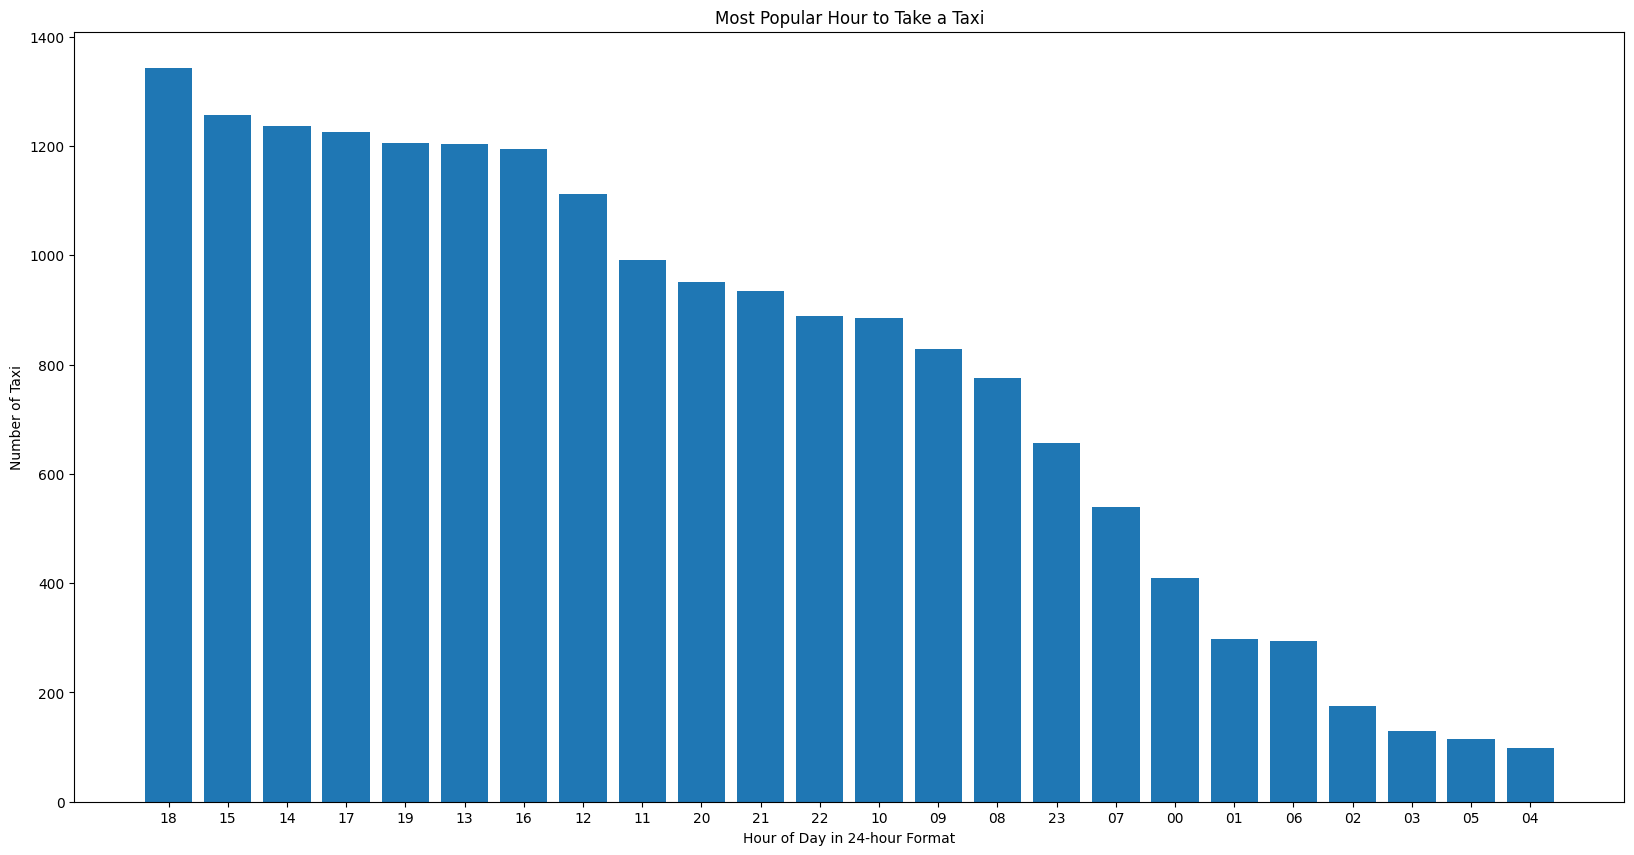

In [171]:
# Show the visualization
popular_hour_to_take_taxi_dataframe = get_data_for_hour_to_take_a_taxi()
plot_most_popular_hour_to_take_a_taxi(popular_hour_to_take_taxi_dataframe)

### Visualization 2

In [172]:
QUERY_AVERAGE_DISTANCE_TRAVELED_PER_MONTH = """
SELECT 
    strftime('%m', pickup_datetime) AS month,
    trip_distance AS distance
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2024-09-01'
UNION ALL
SELECT
    strftime('%m', pickup_datetime) AS month,
    trip_miles AS distance
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2024-09-01'
"""

In [173]:
def plot_average_distance_traveled_per_month(dataframe: pd.DataFrame) -> None:
    """
    Plots the average distance traveled per month based on the provided data.

    Args:
        dataframe (pd.DataFrame): A DataFrame with the following structure:
            - 'month': Month of the year (1-12 as strings).
            - 'distance': Distance traveled in each trip.

    Returns:
        None
    """
    # Group by month
    grouped = dataframe.groupby('month')['distance'].mean().reset_index()
    grouped['month'] = grouped['month'].astype(int)
    grouped = grouped.sort_values('month')
    
    # Define x-axis and y-axis
    x = grouped['month']  
    y = grouped['distance'] 
    dy = 0.9
    
    # Show title and label for error bar
    plt.errorbar(x, y, yerr=dy, fmt='.-', label='Average Distance')
    plt.xticks(
        range(1, 13),
        [
            'Jan', 'Feb', 'Mar',
            'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep',
            'Oct', 'Nov', 'Dec'
        ]
    )
    plt.title('Average Distance Traveled Per Month')
    plt.xlabel('Month')
    plt.ylabel('Average Distance')
    plt.legend()

    # Show plot
    plt.show()

In [174]:
def get_data_for_average_distance_traveled_per_month() -> pd.DataFrame:
    """
    Retrieves data from the database
    for plotting the average distance traveled per month.

    Returns:
        pd.DataFrame:
            A DataFrame containing the results of the SQL query
            with the following structure:
                - 'month': Month of the year (as strings in format 'MM').
                - 'distance': Distance traveled in each trip.
    """
    dataframe = pd.read_sql(
        QUERY_AVERAGE_DISTANCE_TRAVELED_PER_MONTH, con=connection
    )
    return dataframe

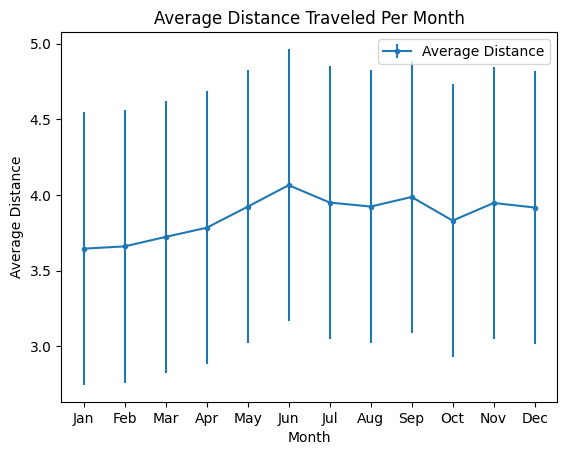

In [175]:
# Show the visualization
some_dataframe = get_data_for_average_distance_traveled_per_month()
plot_average_distance_traveled_per_month(some_dataframe)

### Visualization 3

In [176]:
QUERY_LGA = f"""
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(pickup_datetime) AS number_of_trips
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
    AND dropoff_latitude BETWEEN {LGA_BOX_COORDS[0][0]} 
        AND {LGA_BOX_COORDS[1][0]}
    AND dropoff_longitude BETWEEN {LGA_BOX_COORDS[0][1]}
        AND {LGA_BOX_COORDS[1][1]}
GROUP BY day_of_week
UNION ALL
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(pickup_datetime) AS number_of_trips
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
    AND dropoff_latitude BETWEEN {LGA_BOX_COORDS[0][0]}
        AND {LGA_BOX_COORDS[1][0]}
    AND dropoff_longitude BETWEEN {LGA_BOX_COORDS[0][1]}
        AND {LGA_BOX_COORDS[1][1]}
GROUP BY day_of_week
"""

In [177]:
QUERY_JFK = f"""
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(pickup_datetime) AS number_of_trips
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
    AND dropoff_latitude BETWEEN {JFK_BOX_COORDS[0][0]}
        AND {JFK_BOX_COORDS[1][0]}
    AND dropoff_longitude BETWEEN {JFK_BOX_COORDS[0][1]}
        AND {JFK_BOX_COORDS[1][1]}
GROUP BY day_of_week
UNION ALL
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(pickup_datetime) AS number_of_trips
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
    AND dropoff_latitude BETWEEN {JFK_BOX_COORDS[0][0]}
        AND {JFK_BOX_COORDS[1][0]}
    AND dropoff_longitude BETWEEN {JFK_BOX_COORDS[0][1]}
        AND {JFK_BOX_COORDS[1][1]}
GROUP BY day_of_week
"""

In [178]:
QUERY_EWR = f"""
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(pickup_datetime) AS number_of_trips
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
    AND dropoff_latitude BETWEEN {EWR_BOX_COORDS[0][0]}
        AND {EWR_BOX_COORDS[1][0]}
    AND dropoff_longitude BETWEEN {EWR_BOX_COORDS[0][1]}
        AND {EWR_BOX_COORDS[1][1]}
GROUP BY day_of_week
UNION ALL
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(pickup_datetime) AS number_of_trips
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
    AND dropoff_latitude BETWEEN {EWR_BOX_COORDS[0][0]}
        AND {EWR_BOX_COORDS[1][0]}
    AND dropoff_longitude BETWEEN {EWR_BOX_COORDS[0][1]}
        AND {EWR_BOX_COORDS[1][1]}
GROUP BY day_of_week
"""

In [179]:
def plot_popular_day_for_drop_offs_in_airports(dataframe: pd.DataFrame) -> None:
    """
    Plots a bar graph showing the distribution of drop-offs 
    by day of the week for three airports: LGA, JFK, and EWR.

    Args:
        dataframe (pd.DataFrame): 
            A DataFrame containing the following structure:
                - 'day_of_week' (int):
                    The day of the week (0 = Sunday, 6 = Saturday).
                - 'number_of_trips' (int):
                    The number of trips for the given day and airport.
                - 'airport' (str):
                    The source airport ('LGA', 'JFK', 'EWR').

    Returns:
        None
    """
    # Map day_of_week integers to day names
    day_names = [
        'Sunday', 'Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday', 'Saturday'
    ]
    dataframe['day_name'] = (
        dataframe['day_of_week']
        .astype(int)
        .apply(lambda x: day_names[x])
    )

    # Group by airport and day name
    grouped_data = (
        dataframe.groupby(['airport', 'day_name'])['number_of_trips']
        .sum()
        .reset_index()
    )

    # Pivot data for easier plotting
    pivot_data = (
        grouped_data.pivot(
            index='day_name', columns='airport', values='number_of_trips'
        )
        .fillna(0)
    )
    pivot_data = pivot_data.reindex(day_names)

    # Plot a bar graph for each airport
    pivot_data.plot(kind='bar', figsize=(12, 8), width=0.8)

    # Add titles and labels
    plt.title(
        'Most Popular Day of Week for Drop-Offs in Airports (LGA, JFK, EWR)',
        fontsize=16
    )
    plt.xlabel('Day of the Week', fontsize=14)
    plt.ylabel('Number of Trips', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Airport', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

In [180]:
def get_data_for_popular_day_for_drop_offs_in_airports() -> pd.DataFrame:
    """
    Retrieves and combines data for the most popular day of the week
    for drop-offs at three airports: LGA, JFK, and EWR.

    This function queries the database for each airport,
    appends an 'airport' column to identify the data source, 
    and combines the results into a single DataFrame.

    Returns:
        pd.DataFrame: A combined DataFrame with the following structure:
            - 'day_of_week' (int): 
                The day of the week (0 = Sunday, 6 = Saturday).
            - 'number_of_trips' (int): 
                The number of trips for the given day and airport.
            - 'airport' (str): 
                The source airport ('LGA', 'JFK', 'EWR').
    """
    lga_data = pd.read_sql(QUERY_LGA, connection)
    lga_data['airport'] = 'LGA'
    
    jfk_data = pd.read_sql(QUERY_JFK, connection)
    jfk_data['airport'] = 'JFK'
    
    ewr_data = pd.read_sql(QUERY_EWR, connection)
    ewr_data['airport'] = 'EWR'
    
    # Combine datas into a single DataFrame
    dataframe = pd.concat([lga_data, jfk_data, ewr_data])

    return dataframe

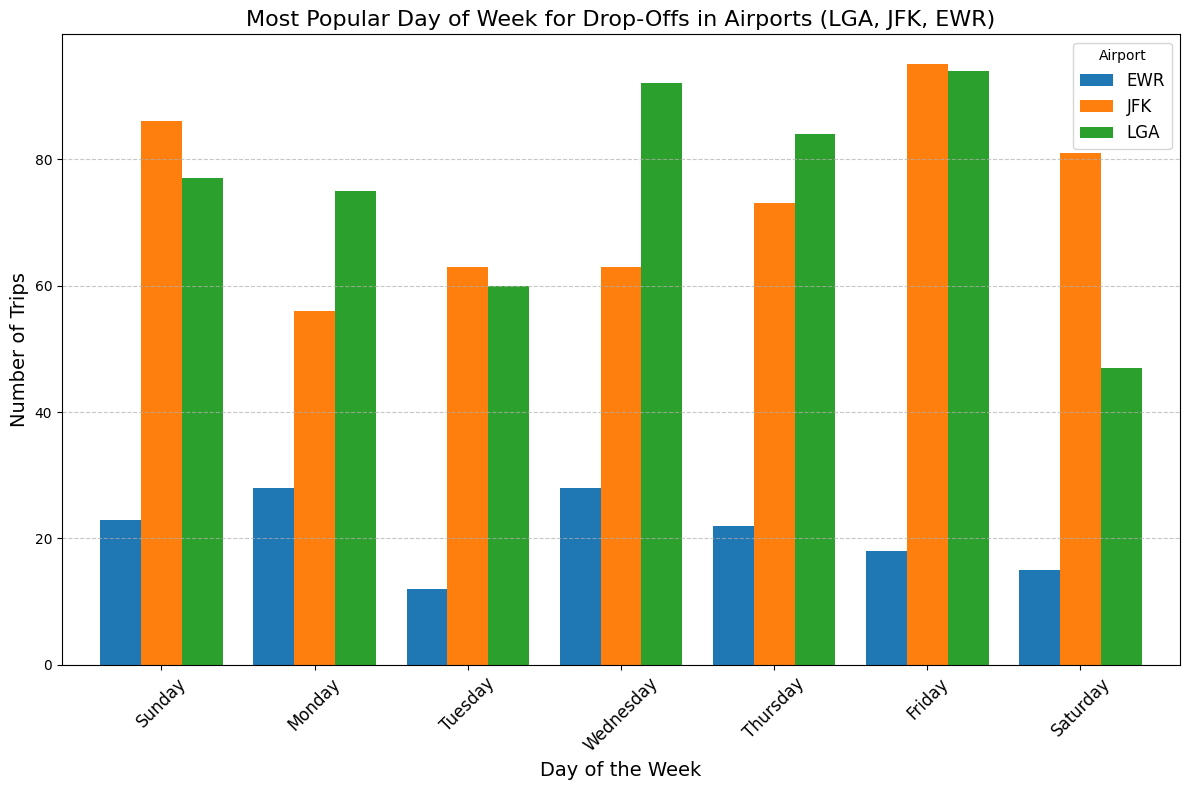

In [181]:
# Show the visualization
some_dataframe = get_data_for_popular_day_for_drop_offs_in_airports()
plot_popular_day_for_drop_offs_in_airports(some_dataframe)

### Visualization 4

In [182]:
QUERY_MONTHLY_TOTAL_FARE_UBER = """
SELECT
    base_passenger_fare AS base_fare,
    all_surcharge AS all_surcharge,
    tolls AS tolls,
    sales_tax AS tax,
    base_passenger_fare + all_surcharge + tolls + sales_tax AS total_fare,
    strftime('%Y-%m', pickup_datetime) AS month_year
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
"""
QUERY_MONTHLY_TOTAL_FARE_TAXI = """
SELECT
    fare_amount AS base_fare, 
    surcharge AS all_surcharge, 
    tolls_amount AS tolls, 
    taxes AS tax,
    fare_amount + surcharge + tolls_amount + taxes AS total_fare,
    strftime('%Y-%m', pickup_datetime) AS month_year
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' 
    AND pickup_datetime < '2024-09-01'
"""

In [183]:
def plot_monthly_earned_total_fares_for_uber_and_taxi(
        uber_fare_data: pd.DataFrame,
        taxi_fare_data: pd.DataFrame
    ) -> None:
    """
    Plots monthly earned total fares for Ubers and Yellow Taxis
    from January 2020 to August 2024,
    broken down by base fares, surcharges, tolls, and taxes.

    Args:
        uber_fare_data (pd.DataFrame): 
            A DataFrame containing Uber trip data with the following columns:
                - 'base_fare' (float): 
                    Total base fare earned for the month.
                - 'all_surcharge' (float):
                    Total surcharges earned for the month.
                - 'tolls' (float):
                    Total tolls earned for the month.
                - 'tax' (float):
                    Total tax earned for the month.
                - 'total_fare' (float):
                    Total fare earned for the month, calculated as 
                    the sum of base fare, surcharges, tolls, and taxes.
                - 'month_year' (str):
                    The month and year of the trip (format 'YYYY-MM').
        taxi_fare_data (pd.DataFrame): 
            A DataFrame containing Yellow Taxi trip data with the same column:
                - 'base_fare' (float):
                    Total base fare earned for the month.
                - 'all_surcharge' (float):
                    Total surcharges earned for the month.
                - 'tolls' (float):
                    Total tolls earned for the month.
                - 'tax' (float):
                    Total tax earned for the month.
                - 'total_fare' (float):
                    Total fare earned for the month, calculated as
                    the sum of base fare, surcharges, tolls, and taxes.
                - 'month_year' (str):
                    The month and year of the trip (format 'YYYY-MM').

    Returns:
        None
    """
    # X-axis positions
    all_months = pd.date_range(start='2020-01', end='2024-08', freq='MS')
    months = all_months.strftime('%Y-%m')
    x = np.arange(len(months))  

    # Sorted by month_year
    uber_fare_data = uber_fare_data.groupby('month_year', as_index=False).sum()
    taxi_fare_data = taxi_fare_data.groupby('month_year', as_index=False).sum()


    fig, axs = plt.subplots(2, 1, figsize=(16, 12))

    # Uber stacked bar chart
    axs[0].bar(
        x,
        uber_fare_data['base_fare'],
        label='Uber Base Fare',
        color='lightblue'
    )
    axs[0].bar(
        x,
        uber_fare_data['all_surcharge'],
        bottom=uber_fare_data['base_fare'],
        label='Uber Surcharge',
        color='orange'
    )
    axs[0].bar(
        x, uber_fare_data['tolls'], 
        bottom=(
            uber_fare_data['base_fare']
            + uber_fare_data['all_surcharge']
        ),
        label='Uber Tolls',
        color='green'
    )
    axs[0].bar(
        x,
        uber_fare_data['tax'],
        bottom=(
            uber_fare_data['base_fare']
            + uber_fare_data['all_surcharge']
            + uber_fare_data['tolls']
        ),
        label='Uber Tax',
        color='salmon'
    )
    axs[0].set_title('Monthly Earned Total Fares for Uber (2020-2024)')
    axs[0].set_ylabel('Total Amount ($)')
    axs[0].legend(loc='upper left')
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Taxi stacked bar chart
    axs[1].bar(
        x, 
        taxi_fare_data['base_fare'],
        label='Taxi Base Fare',
        color='lightblue'
        )
    axs[1].bar(
        x,
        taxi_fare_data['all_surcharge'],
        bottom=taxi_fare_data['base_fare'],
        label='Taxi Surcharge',
        color='orange'
    )
    axs[1].bar(
        x,
        taxi_fare_data['tolls'],
        bottom=(
            taxi_fare_data['base_fare'] 
            + taxi_fare_data['all_surcharge']
        ),
        label='Taxi Tolls',
        color='green'
    )
    axs[1].bar(
        x,
        taxi_fare_data['tax'],
        bottom=(
            taxi_fare_data['base_fare']
            + taxi_fare_data['all_surcharge']
            + taxi_fare_data['tolls']
        ),
        label='Taxi Tax',
        color='salmon'
    )
    axs[1].set_title('Monthly Earned Total Fares for Yellow Taxis (2020-2024)')
    axs[1].set_xlabel('Month')
    axs[1].set_ylabel('Total Amount ($)')
    axs[1].legend(loc='upper left')
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)

    # X-axis labels for both charts
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(months, rotation=45)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(months, rotation=45)

    # Show graph
    plt.tight_layout()
    plt.show()

In [184]:
def get_data_for_monthly_total_fare() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fetches and processes data for monthly earned total fares
    for Ubers and Yellow Taxis.

    This function executes the provided SQL queries to retrieve data
    for Uber and Yellow Taxi monthly earned total fares,
    including base fare, surcharges, tolls, tax, and total fare.

    Args:
        None

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two DataFrames:
            - uber_data: 
            DataFrame for Uber trip data 
            with monthly aggregated fare details.
            - taxi_data: DataFrame for Taxi trip data
            with monthly aggregated fare details.
    """
    uber_fare_data = pd.read_sql(QUERY_MONTHLY_TOTAL_FARE_UBER, con=connection)
    taxi_fare_data = pd.read_sql(QUERY_MONTHLY_TOTAL_FARE_TAXI, con=connection)
    
    return uber_fare_data, taxi_fare_data

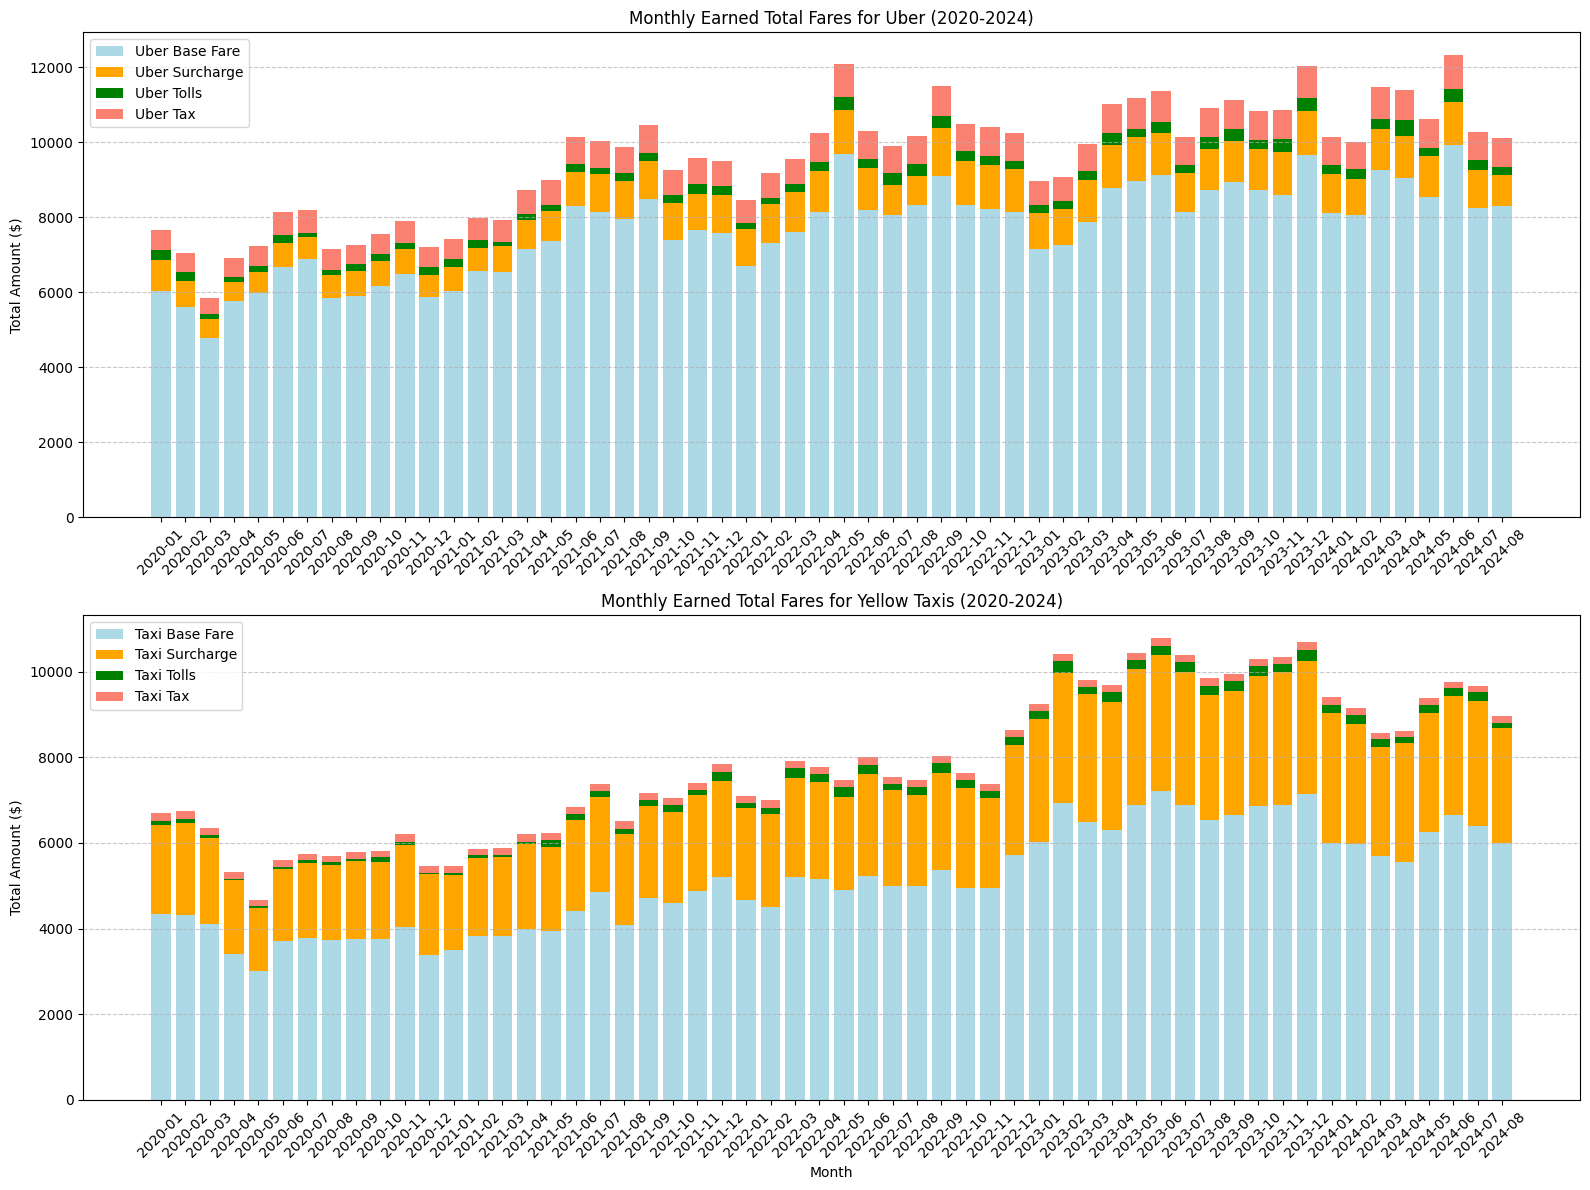

In [185]:
# Show the visualization
uber_fare_data, taxi_fare_data = get_data_for_monthly_total_fare()
plot_monthly_earned_total_fares_for_uber_and_taxi(uber_fare_data, taxi_fare_data)

### Visualization 5

In [186]:
QUERY_TAXI_TIP = """
SELECT 
    trip_distance AS distance,
    tip_amount AS tip,
    pickup_datetime,
    daily_weather.DailyPrecipitation AS precipitation
FROM taxi_trips
JOIN daily_weather
    ON DATE(taxi_trips.pickup_datetime) = daily_weather.DATE
WHERE pickup_datetime >= '2022-01-01' 
    AND pickup_datetime < '2024-01-01'
"""

QUERY_UBER_TIP = """
SELECT 
    trip_miles AS distance,
    tips AS tip,
    pickup_datetime,
    daily_weather.DailyPrecipitation AS precipitation
FROM uber_trips
JOIN daily_weather
    ON DATE(uber_trips.pickup_datetime) = daily_weather.DATE
WHERE pickup_datetime >= '2022-01-01' 
    AND pickup_datetime < '2024-01-01'
"""

In [187]:
def plot_uber_tip_effects(
        uber_tip_data: pd.DataFrame,
        taxi_tip_data: pd.DataFrame
    ) -> None:
    """
    Plots scatter plots to analyze how tips are affected by 
    distance and precipitation for Uber and Yellow Taxi data.

    Args:
        uber_tip_data (pd.DataFrame): 
            A DataFrame containing Uber data with columns:
                - 'distance': The distance of the trip in miles.
                - 'tip': The tip amount for the trip.
                - 'precipitation': The precipitation level during the trip.
        taxi_tip_data (pd.DataFrame): 
            A DataFrame containing Yellow Taxi data with columns:
                - 'distance': The distance of the trip in miles.
                - 'tip': The tip amount for the trip.
                - 'precipitation': The precipitation level during the trip.

    Returns:
        None
    """
    fig, axs = plt.subplots(2, 2)
    # Analyze how Uber tips are affected by distance
    axs[0, 0].scatter(taxi_tip_data['distance'], taxi_tip_data['tip'])
    axs[0, 0].set_title('Yellow Taxi: Tip vs. Distance')
    axs[0, 0].set_xlabel('Distance in miles')
    axs[0, 0].set_ylabel('Tip')

    axs[0, 1].scatter(uber_tip_data['distance'], uber_tip_data['tip'])
    axs[0, 1].set_title('Uber: Tip vs. Distance')
    axs[0, 1].set_xlabel('Distance in miles')
    axs[0, 1].set_ylabel('Tip')

    # Analyze how Uber tips are affected by precipitation
    axs[1, 0].scatter(taxi_tip_data['precipitation'], taxi_tip_data['tip'])
    axs[1, 0].set_title('Yellow Taxi: Tip vs. Precipitation')
    axs[1, 0].set_xlabel('Precipitation')
    axs[1, 0].set_ylabel('Tip')

    axs[1, 1].scatter(uber_tip_data['precipitation'], uber_tip_data['tip'])
    axs[1, 1].set_title('Uber: Tip vs. Precipitation')
    axs[1, 1].set_xlabel('Precipitation')
    axs[1, 1].set_ylabel('Tip')

    # Show graph
    plt.tight_layout()
    plt.show

In [188]:
def get_data_for_uber_tip_effects() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fetches data for Uber and Yellow Taxi 
    to analyze the effect of distance and precipitation on tips.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Two DataFrames:
            - Uber data with columns ['distance', 'tip', 'precipitation'].
            - Yellow Taxi data with columns
            ['distance', 'tip', 'precipitation'].
    """
    uber_tip_data = pd.read_sql(QUERY_UBER_TIP, con=connection)
    taxi_tip_data = pd.read_sql(QUERY_TAXI_TIP, con=connection)
    return uber_tip_data, taxi_tip_data

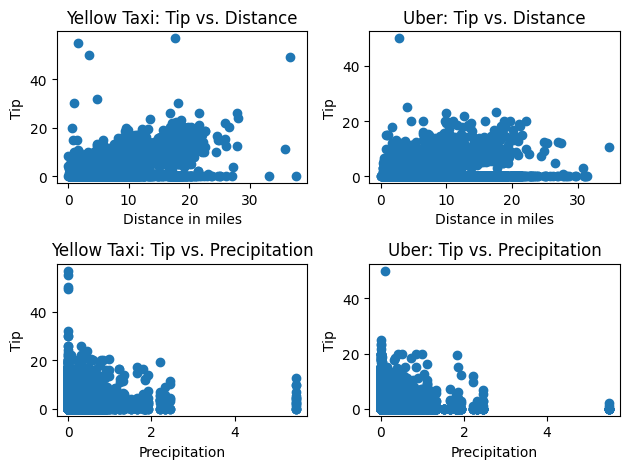

In [189]:
# Show the visualization
uber_tip_data, taxi_tip_data = get_data_for_uber_tip_effects()
plot_uber_tip_effects(uber_tip_data, taxi_tip_data)

### Visualization 6

In [190]:
QUERY_LOCATION = """
SELECT 
    pickup_latitude,
    pickup_longitude,
    dropoff_latitude,
    dropoff_longitude
FROM taxi_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2021-01-01'
UNION ALL
SELECT 
    pickup_latitude,
    pickup_longitude,
    dropoff_latitude,
    dropoff_longitude
FROM uber_trips
WHERE pickup_datetime >= '2020-01-01' AND pickup_datetime < '2021-01-01';
"""

In [191]:
def plot_all_hired_trips_in_2020_over_map(dataframe: pd.DataFrame) -> None:
    """
    Plots a heatmap of all hired trips in 2020 over a map of New York City.

    This function filters trips within
    specified New York City bounding box coordinates
    and visualizes pickup and dropoff locations
    using a heatmap overlay on a Folium map.

    Args:
        dataframe (pd.DataFrame): 
            A DataFrame containing the following columns:
                - 'pickup_latitude' (float):
                    Latitude of the trip's pickup location.
                - 'pickup_longitude' (float):
                    Longitude of the trip's pickup location.
                - 'dropoff_latitude' (float):
                    Latitude of the trip's dropoff location.
                - 'dropoff_longitude' (float):
                    Longitude of the trip's dropoff location.
    
    Returns:
        folium.Map: A Folium map object with
        a heatmap overlay showing trip locations.
    """
    # In the NYC area
    dataframe = dataframe[
        (dataframe['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) &
        (dataframe['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) &
        (dataframe['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0]) &
        (dataframe['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0]) &
        (dataframe['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) &
        (dataframe['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) &
        (dataframe['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1]) &
        (dataframe['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1]) 
    ]

    # Locate folium map
    center_latitude = (
        NEW_YORK_BOX_COORDS[0][0]
        + NEW_YORK_BOX_COORDS[1][0]
    ) / 2
    center_longitude = (
        NEW_YORK_BOX_COORDS[0][1]
        + NEW_YORK_BOX_COORDS[1][1]
    ) / 2
    nyc_map = folium.Map(location=[center_latitude, center_longitude])
    
    # Add both pick-up locations and drop-off locations into map
    pickup_locations = (
        dataframe[
            [
                'pickup_latitude',
                'pickup_longitude'
            ]
        ]
        .values
        .tolist()
    )
    dropoff_locations = (
        dataframe[
            [
                'dropoff_latitude',
                'dropoff_longitude'
            ]
        ]
        .values
        .tolist()
    )
    all_location = pickup_locations + dropoff_locations

    HeatMap(all_location, radius = 10).add_to(nyc_map)

    return nyc_map

In [192]:
def get_data_for_all_hired_trips_in_2020_over_map() -> pd.DataFrame:
    """
    Retrieves data for all hired trips in 2020 to plot on a map.
    
    This function executes a SQL query
    to fetch pickup and dropoff latitude/longitude
    data for trips that occurred between January 1, 2020, and December 31, 2020.
    
    Returns:
        pd.DataFrame: 
            A DataFrame containing the following columns:
                - 'pickup_latitude' (float):
                    Latitude of the trip's pickup location.
                - 'pickup_longitude' (float):
                    Longitude of the trip's pickup location.
                - 'dropoff_latitude' (float):
                    Latitude of the trip's dropoff location.
                - 'dropoff_longitude' (float):
                    Longitude of the trip's dropoff location.
    """
    dataframe = pd.read_sql(QUERY_LOCATION, con=connection)
    return dataframe

In [193]:
# Show the visualization
some_dataframe = get_data_for_all_hired_trips_in_2020_over_map()
plot_all_hired_trips_in_2020_over_map(some_dataframe)

Annotation: Folium utilized both drop-off and pick-up locations.

## Extra Credit: Additional table and query for sunset/sunrise data

### Create sunset/sunrise data

In [194]:
def clean_month_weather_data_sunset_sunrise(
        csv_file: pd.DataFrame
    ) -> pd.DataFrame:
    """
    Cleans weather data by extracting DATE, Sunset, and Sunrise columns, 
    and normalizing them in datetime format. 

    Parameter:
        csv_file (pd.DataFrame): 
            The input file of date containing weather information.

    Returns:
        pd.DataFrame: 
            A cleaned DataFrame with 'DATE', 'Sunset', 'Sunrise'.
    """
    sun_data = csv_file.copy()

    # Convert date in datetime foramt and only consider the year-month-date
    sun_data['DATE'] = pd.to_datetime(sun_data['DATE'])
    sun_data['DATE'] = sun_data['DATE'].dt.strftime('%Y-%m-%d')
    sun_data['DATE'] = pd.to_datetime(sun_data['DATE'])
    
    # Drop other times without sunset/sunrise information
    sun_data = sun_data.dropna(subset=['Sunrise', 'Sunset'], how='all')
    
    # Convert Sunrise and Sunset to time format (hh:mm)
    sun_data['Sunrise'] = (
        pd.to_datetime(sun_data['Sunrise'],format='%H%M')
        .dt
        .strftime('%H:%M')
    )
    sun_data['Sunset'] = (
        pd.to_datetime(sun_data['Sunset'], format='%H%M')
        .dt
        .strftime('%H:%M')
    )

    sun_data = sun_data[['DATE','Sunrise','Sunset']].reset_index(drop=True)
    
    return sun_data

In [195]:
def load_and_clean_weather_data() -> pd.DataFrame:
    """
    Loads and cleans daily dataframes to only contains Sunset/Sunrise time 
    from CSV files.
    
    Returns:
        pd.DataFrame: A dataframe contains daily Sunset/Sunrise time
    """
    weather_csv_files = get_all_weather_csvs()
    
    sun_dataframes = []
    
    # Receives daily weather data for each year and clean it
    for csv_file in weather_csv_files:
        sun_dataframe = clean_month_weather_data_sunset_sunrise(csv_file)
        sun_dataframes.append(sun_dataframe)

        
    # Create a dataframe that combines all daily sunset/sunrise data 
    sun_data = pd.concat(sun_dataframes)
    
    return sun_data

In [196]:
sun_time_data = load_and_clean_weather_data()
sun_time_data

,DATE,Sunrise,Sunset
0,2020-01-01,07:20,16:39
1,2020-01-02,07:20,16:40
2,2020-01-03,07:20,16:41
3,2020-01-04,07:20,16:42
4,2020-01-05,07:20,16:43
...,...,...,...
290,2024-10-17,06:10,17:11
291,2024-10-18,06:11,17:10
292,2024-10-19,06:12,17:08
293,2024-10-20,06:13,17:07


### Create the table using sql

In [197]:
# Create the table
with connection:
    connection.execute("""
    Create Table IF NOT EXISTS daily_sun_time (
        id INTEGER PRIMARY KEY,
        DATE DATETIME,
        Sunrise DATETIME,
        Sunset DATETIME)
    """)

sun_query = """
            INSERT INTO daily_sun_time(DATE,
                                      Sunrise,
                                      Sunset)
            VALUES (?, ?, ?)
            """

data = []
# Loop through DataFrame rows and insert each row into the table
for index, row in sun_time_data.iterrows():
    DATE = row['DATE'].strftime('%Y-%m-%d') 
    Sunrise = row['Sunrise']
    Sunset = row['Sunset']
    data.append((
    DATE,
    Sunrise,
    Sunset
    ))
        
with connection:
    connection.executemany(sun_query,data)

### Top 10 Dates with the Most Taxi Requests Between Sunrise and Sunset from 2020-2023


In [198]:
QUERY_7_FILENAME = "Top_10_with_most_taxi_requests_in_daytime.sql"

QUERY_7 = """
SELECT
    s.DATE,
    COUNT(*) AS count
FROM
    taxi_trips AS t
JOIN
    daily_sun_time AS s
ON
    strftime('%Y-%m-%d', t.pickup_datetime) = s.DATE
WHERE
    strftime('%Y-%m-%d', t.pickup_datetime) BETWEEN '2020-01-01'
        AND '2023-12-31'
    AND strftime('%H', t.pickup_datetime) >= strftime('%H', s.Sunrise)
    AND strftime('%H', t.pickup_datetime) <= strftime('%H', s.Sunset)
GROUP BY
    s.DATE
ORDER BY
    count DESC
LIMIT 10;

"""

In [199]:
# Show the result
pd.read_sql(QUERY_7, con=connection)

,DATE,count
0,2020-04-29,21
1,2020-03-03,21
2,2020-07-02,20
3,2020-03-07,20
4,2020-11-24,18
5,2020-03-05,18
6,2022-08-18,17
7,2021-07-17,17
8,2021-04-14,17
9,2020-09-16,17


In [200]:
write_query_to_file(QUERY_7, QUERY_7_FILENAME)

## Extra Credit: Create Animation

In [201]:
def animate_most_popular_hour_to_take_a_taxi(dataframe: pd.DataFrame) -> None:
    """
    Animates a bar chart showing the most popular hours to take a taxi
    based on the provided data.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing two columns:
            - 'hour_of_day': The hour of the day (0-23) in 24-hour format.
            - 'number_of_taxi': The number of taxis taken at each hour.

    Returns:
        None
    """
    hours = dataframe['hour_of_day']
    taxi_counts = dataframe['number_of_taxi']

    figure, axes = plt.subplots(figsize=(20, 10))
    bars = axes.bar(hours, [0] * len(hours), color="blue")
    axes.set_xlabel('Hour of Day in 24-hour Format', fontsize=14)
    axes.set_xticks(hours)
    axes.set_xticklabels(hours, fontsize=12)
    axes.set_ylabel('Number of Taxis', fontsize=14)
    axes.set_title("Most Popular Hour to Take a Taxi", fontsize=16)
    axes.set_ylim(0, max(taxi_counts) + 50)
    
    # Update function for animation
    def update(frame):
        # Dynamically update bar heights
        for bar, height in zip(bars, taxi_counts[:frame + 1]):
            bar.set_height(height)
        return bars
    
    # Create animation
    ani = animation.FuncAnimation(
        figure,
        update,
        frames=len(taxi_counts),
        repeat=False,
        interval=200,
        blit=False
    )
    
    # Save animation as a GIF using Pillow
    ani.save("most_popular_hour_taxi_animation.gif", writer="pillow")
    
    return Image("most_popular_hour_taxi_animation.gif")


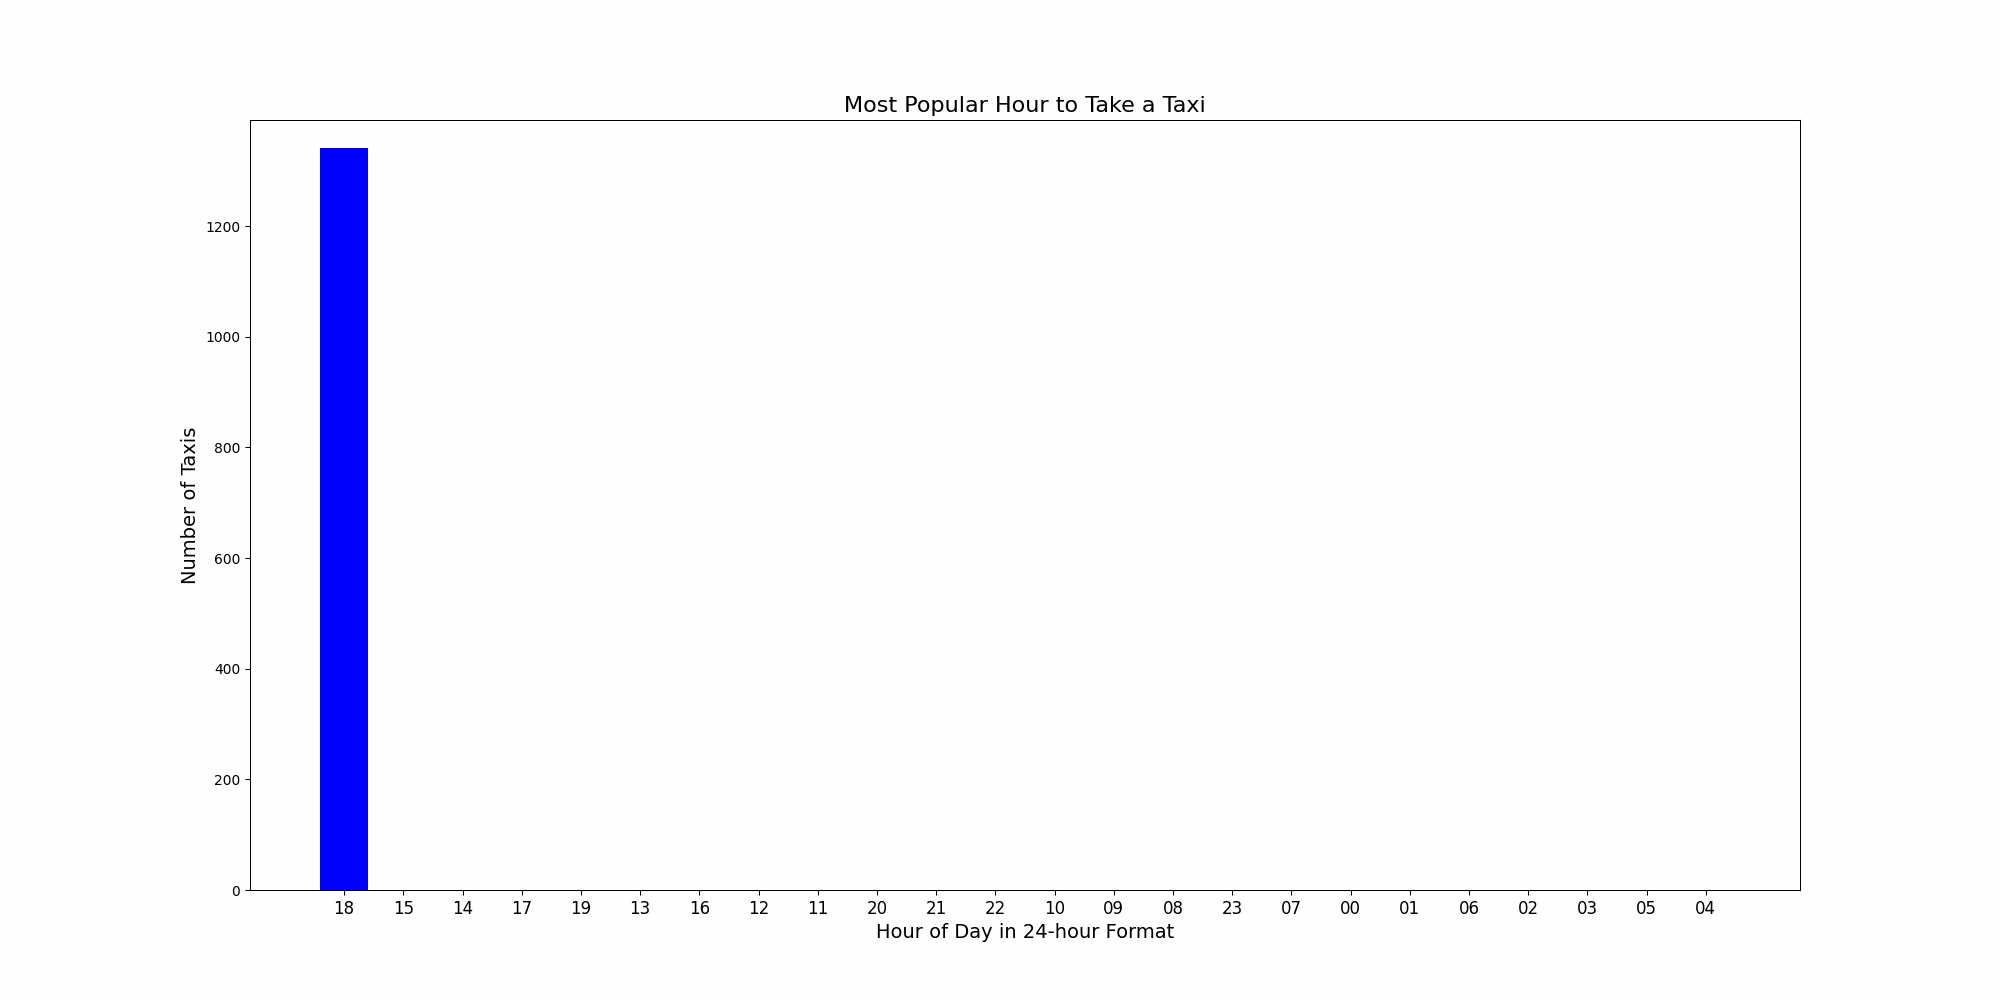

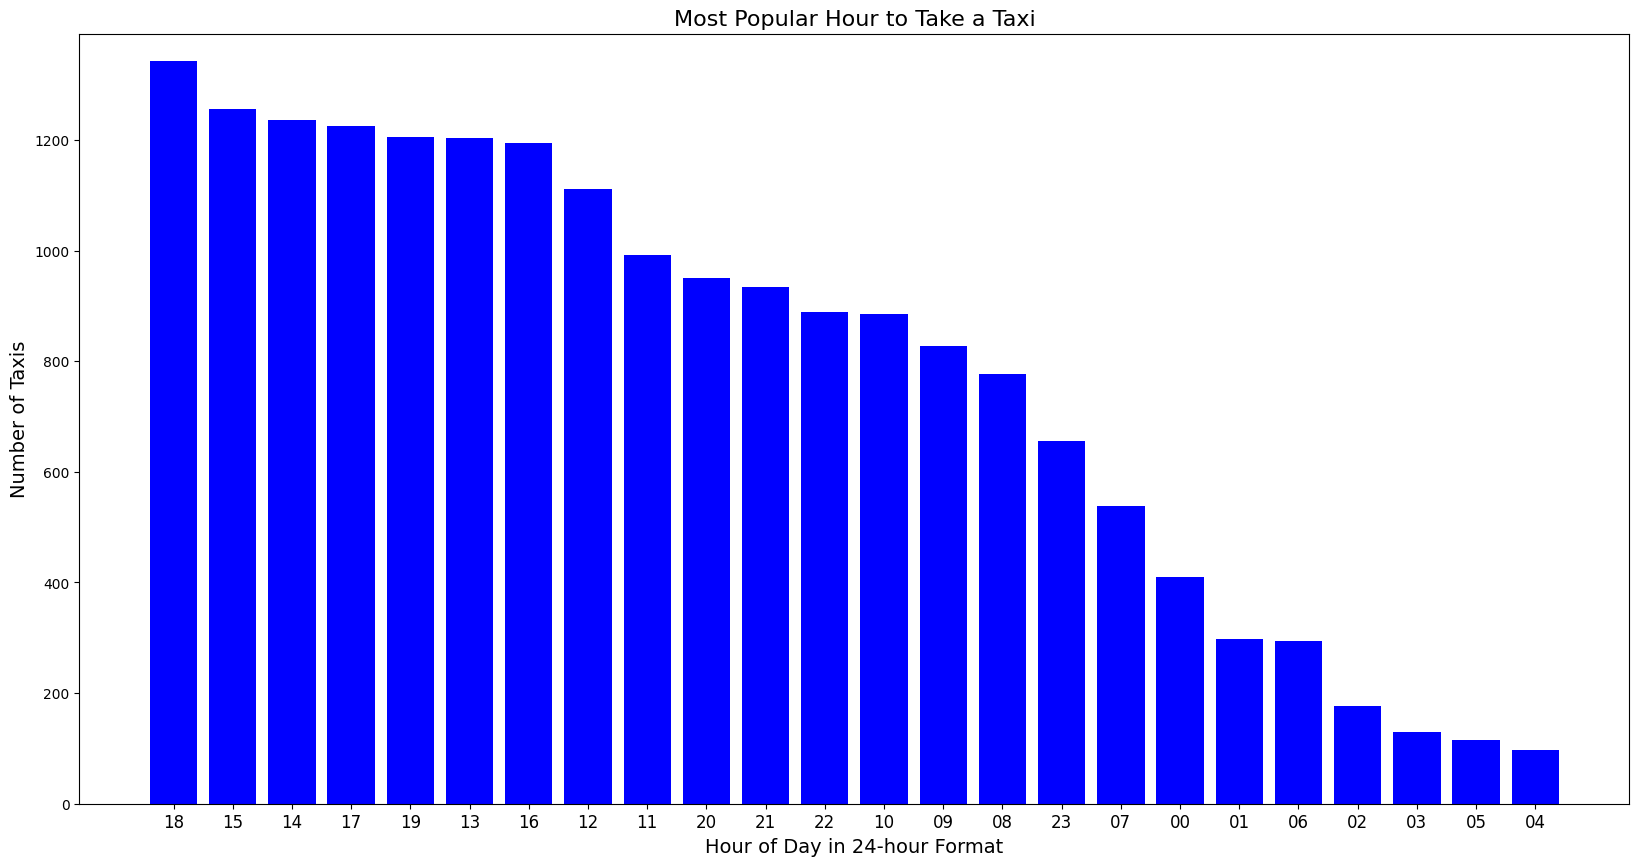

In [202]:
# Show the visualization
animate_most_popular_hour_to_take_a_taxi(popular_hour_to_take_taxi_dataframe)